### Pooled Pbe detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.analyses import detect_pbe_epochs
import subjects
import pandas as pd
from scipy import stats

sessions = subjects.sd.ratVday2+ subjects.nsd.ratVday1 

In [ ]:
for sub,sess in enumerate(sessions):

    mua =sess.neurons.get_mua()
    mua.save(sess.filePrefix.with_suffix(".mua.npy")) 

    smth_mua = mua.get_smoothed(sigma=0.02)
    pbe = detect_pbe_epochs(smth_mua)
    pbe.save(sess.filePrefix.with_suffix('.pbe'))

### Pbe rate change across sleep deprivation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    +subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2

    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

# sessions = subjects.sd.utkuAG_day1 + subjects.sd.utkuAG_day2

In [ ]:
pbe_rate_df = pd.DataFrame()
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    period = [post[0], post[0] + 9* 3600]
    pbe = sess.pbe.starts

    binsz = 3600
    n_bins = np.diff(period)/ binsz
    sd_bin = np.arange(n_bins + 1) * binsz + period[0]
    hist_pbe = np.histogram(pbe, bins=sd_bin)[0]

    pbe_rate_df = pbe_rate_df.append(
        pd.DataFrame(
            {
                "rate": hist_pbe / binsz,
                "Zt": (sd_bin[:-1] - sd_bin[0]) / 3600 +1,
                "sub": sub,
                "grp": sess.tag,
            }
        ),
        ignore_index=True,
    )

subjects.GroupData().save(pbe_rate_df,'pbe_rate')

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

figure = Fig()
fig, gs = figure.draw(grid=(5, 4))

for i, grp in enumerate(["sd",'nsd']):
    df = pbe_rate_df[pbe_rate_df["grp"] == grp]
    ax = plt.subplot(gs[i])
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        ax=ax,
        hue="sub",
        legend=False,
        palette="#BDBDBD",
        # ls="--",
    )
    sns.lineplot(
        data=df,
        x="Zt",
        y="rate",
        estimator=np.median,
        ax=ax,
        legend=False,
        color='k',
        ls="--",
        ci=None,
        lw=2,
    )
    # ax.set_yscale('log')
    # ax.set_ylim([0.08, 0.65])
    ax.set_xticks(np.arange(1, 10, 2))

# figure.savefig(subjects.figpath_sd/'ripple_rate')

### Total/mean pbe duration from first hour to last hour SD

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)


In [15]:
pbe_duration = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    starts = np.arange(9) * 3600 + post[0]
    stops = starts + 3600

    #POST is not necessarily 9 hours long
    stops[-1] = np.min([post[1],stops[-1]])

    for i, (t1,t2) in enumerate(zip(starts, stops)):

        pbe_duration.append(
            pd.DataFrame(
                {
                    "Zt": f"{i+1}",
                    "pbe_duration": [sess.pbe.time_slice(t1, t2).durations.sum()],
                    "grp": sess.tag,
                    "sub": sub,
                }
            ),
        )

pbe_duration = pd.concat(pbe_duration, ignore_index=True)
subjects.GroupData().save(pbe_duration, "pbe_total_duration")


pbe_total_duration saved


In [16]:
stops-starts

array([3600, 3600, 3600, 3600, 3600, 3600, 3600, 3600, 3600])

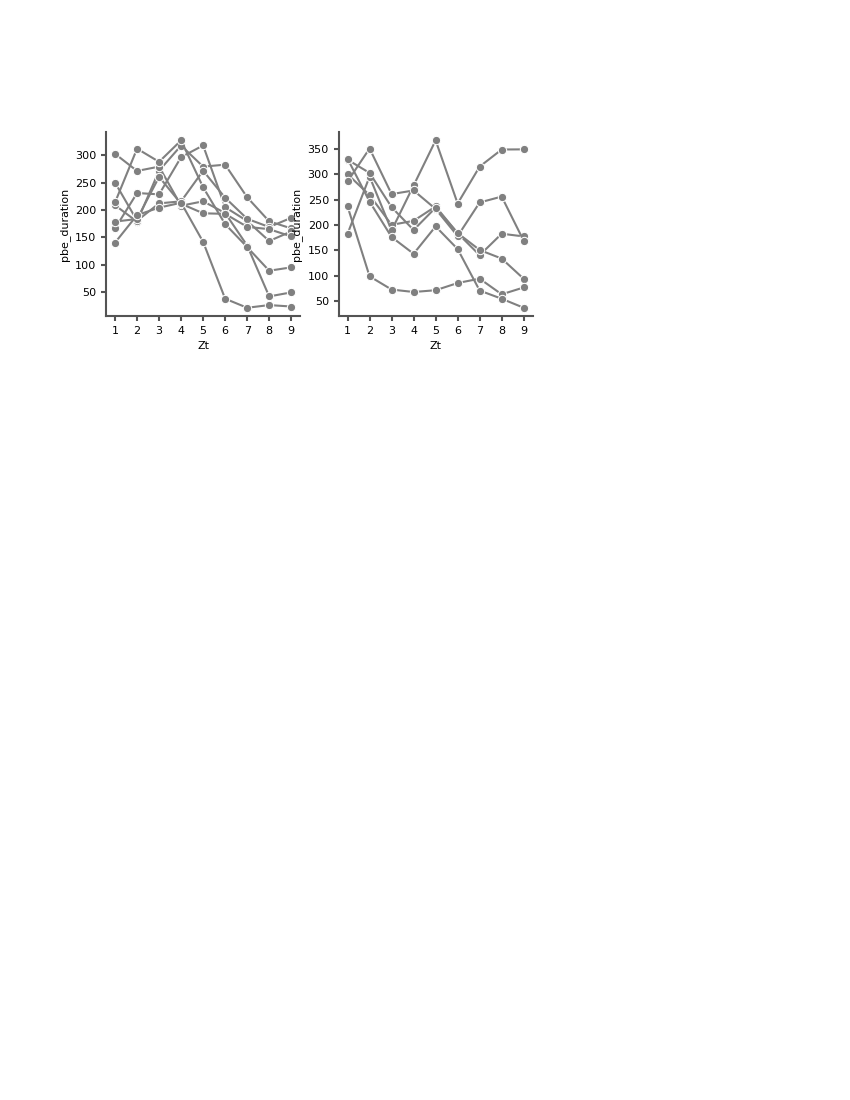

In [20]:
%matplotlib widget
import seaborn as sns
from neuropy import plotting

fig = plotting.Fig(grid=(4, 3))
n_subs = [7,6]
for i, grp in enumerate(["SD", "NSD"]):
    data = pbe_duration[pbe_duration["grp"] == grp]
    ax = fig.subplot(fig.gs[i])
    sns.lineplot(
        data=data,
        x="Zt",
        y="pbe_duration",
        hue="sub",
        marker="o",
        palette=["gray"] * n_subs[i],
        ax=ax,
        legend=None,
    )
    # ax.set_xlim([-1,6])
    # ax.set_ylim([30,450])


# g=sns.relplot(
#     data=rpl_duration,
#     x="epoch",
#     y="rpl_duration",
#     hue="sub",
#     col="grp",
#     # row='rpl_duration',
#     kind="line",
#     marker="o",
#     palette=['gray']*len(sessions),
# )

# [ax.set_xlim([-1,2]) for ax in g.axes.reshape(-1)]
# figure.savefig(subjects.figpath_sd/'ripple_total_duration_zt1_vs_zt5')